# Programming problem 2
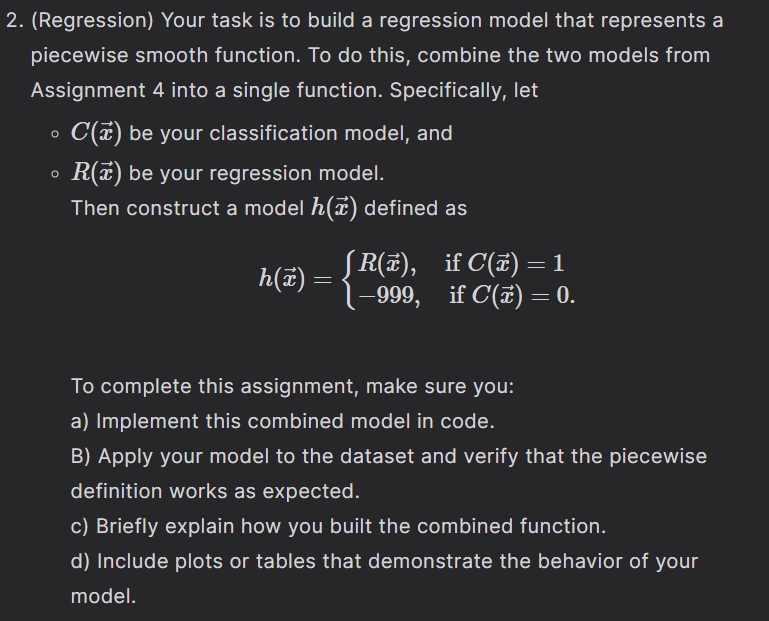

---

[GDA] test accuracy = 0.5343283582089552
[GDA] confusion matrix:
 [[1074    6]
 [ 930    0]]


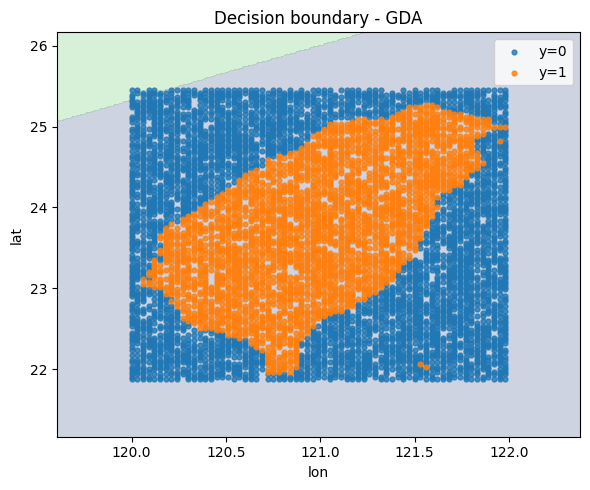

In [8]:
import re, math, numpy as np
import pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
df_cls = pd.read_csv("classification_dataset.csv")

import sys
sys.path.append(r"C:\Users\user\OneDrive - 國立陽明交通大學\桌面\001__1141碩士生存指南\536708_機器學習_林得勝\2025_machine_learning\Week_6\wk6_models.py")

import wk6_models as wk6

# 假設裡面有定義 C(x) 和 R(x)
#y_pred_class = wk6.C.predict(X)
#y_pred_reg = wk6.R.predict(X)
xcols, ycol = wk6.infer_columns(df_cls, y_hint=None)
X = df_cls[xcols].to_numpy(dtype=float)
y = df_cls[ycol].to_numpy(dtype=int)

X_tr, X_te, y_tr, y_te = wk6.train_test_split_xy(X, y, test_size=0.25, seed=7)

gda = wk6.GDA(reg=1e-6).fit(X_tr, y_tr)
pred_te = gda.predict(X_te)
print("[GDA] test accuracy =", wk6.accuracy(y_te, pred_te))
print("[GDA] confusion matrix:\n", wk6.confusion_matrix(y_te, pred_te))
wk6.plot_decision_boundary(gda, X_tr, y_tr, xcols)


In [ ]:
def h(x):
    if C(x)==1:
        return R(x)
    else:
        return -999
